## Probabilistic Matrix Factorization using the MovieLens Dataset

In [129]:
%matplotlib inline
import time

import pandas as pd
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

from numpy.linalg import inv

In [130]:
# Run this when you haven't created a indexed_ratings.csv yet
# Data: https://www.kaggle.com/rounakbanik/the-movies-dataset/download
ratings = pd.read_csv('../data/the-movies-dataset/ratings_small.csv')

# Check the minimum number of ratings a user has posted
print('Minimum number of ratings for each user is ' + str(ratings.groupby('userId').size().min()))
print('Minimum number of ratings for each movie is ' + str(ratings.groupby('movieId').size().min()))

Minimum number of ratings for each user is 20
Minimum number of ratings for each movie is 1


In [131]:
# We will only use part of the data that has more than 4 reviews per movie
moviecounts = ratings.movieId.value_counts()
ratings = ratings[ratings.movieId.isin(moviecounts.index[moviecounts.gt(4)])].reset_index(drop=True)
print('Minimum number of ratings for each movie is ' + str(ratings.groupby('movieId').size().min()))

Minimum number of ratings for each movie is 5


In [132]:
unique_userId = ratings.userId.unique()
unique_movieId = ratings.movieId.unique()

ratings['new_user_index'], ratings['new_movie_index'] = 0, 0

for old_id, new_id in zip(unique_userId, range(len(unique_userId))):
    ratings['new_user_index'].iloc[ratings[ratings['userId']==old_id].index.tolist()] = new_id

for old_id, new_id in zip(unique_movieId, range(len(unique_movieId))):
    ratings['new_movie_index'].iloc[ratings[ratings['movieId']==old_id].index.tolist()] = new_id

ratings.to_csv('../data/indexed_ratings.csv')

In [142]:
# Run this when you have a indexed_ratings.csv 
ratings = pd.read_csv('../data/indexed_ratings.csv', index_col=0)

In [144]:
# Randomly split the data into train and test
# Specifically, take 5 random ratings out from each user's rating list (therefore, there will be 5 times # of user ratings in the test set)

# For each user id, take out 5 ratings out of the dataframe then append them into a new dataframe.
# Then take the difference of the two data frames and the difference will be the train data
for userid in ratings.userId.unique() :
    if userid == 1:
        test_ratings = ratings[ratings['userId']==userid].sample(5, random_state=0)
    else:
        test_ratings = test_ratings.append(ratings[ratings['userId']==userid].sample(5, random_state=0))
train_ratings = pd.concat([ratings, test_ratings]).drop_duplicates(keep=False).reset_index(drop=True)
test_ratings = test_ratings.reset_index(drop=True)
print("Number of ratings in entire dataset is "+ str(len(ratings)))
print("Number of ratings in entire dataset is "+  str(len(train_ratings)))
print("Number of ratings in entire dataset is "+ str(len(test_ratings)))

Number of ratings in entire dataset is 90072
Number of ratings in entire dataset is 86717
Number of ratings in entire dataset is 3355


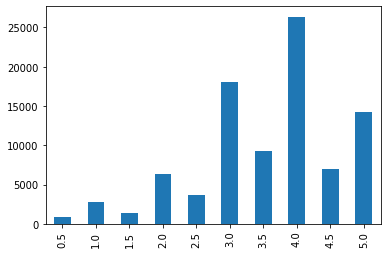

In [151]:
# Distribution of All Ratings (with more than 4 reviews)
ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

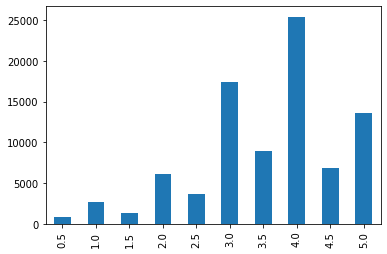

In [152]:
# Distribution of Train Data Ratings
train_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

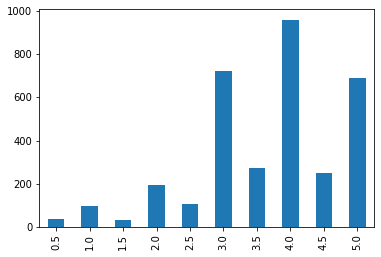

In [153]:
# Distribution of Test Data Ratings
test_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

In [197]:
# Reference: https://sandipanweb.wordpress.com/2017/04/04/probabilistic-matrix-factorization-with-a-generative-model-in-python/
# Implementation of Probabilistic Matrix Factorization
class PMF:
    def __init__(self, k, prior_mean=0, prior_std=1, epochs=20):
        self.k = k
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.epochs = epochs
        self.u = None
        self.v = None
        self.M_prime = None
        
    def fit(self, data):
        ratings = data
        self.I = ratings.userId.nunique()
        self.J = ratings.movieId.nunique()
        self.u = pyro.sample("user_factor", pyro.distributions.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.I,self.k]))
        self.v = pyro.sample("movie_factor", pyro.distributions.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.J,self.k]))
        self.data_var = ratings['rating'].var(axis=0)
        
        user_to_movie_dict = {}
        movie_to_user_dict = {}

        for i in range(self.I):
            user_to_movie_dict[i] = ratings[ratings['new_user_index']==i]['new_movie_index'].tolist()
        for j in range(self.J):
            movie_to_user_dict[j] = ratings[ratings['new_movie_index']==j]['new_user_index'].tolist()
            
        for epoch_num in range(self.epochs):
            # Update of all u_i: Took 110.703 seconds on Yuki's cp
            for i in range(len(self.u)):
                v_sum = 0
                mv_sum = 0
                for j in user_to_movie_dict[i]:
                    v_sum += np.outer(self.v[j],self.v[j])
                    mv_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.v[j]
                self.u[i] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + v_sum), mv_sum))

            # Update of all v_j: Took 106.218 seconds on Yuki's cp
            for j in range(len(self.v)):
                u_sum = 0
                mu_sum = 0
                for i in movie_to_user_dict[j]:
                    u_sum += np.outer(self.u[i],self.u[i])
                    mu_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.u[i]
                self.v[j] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + u_sum), mu_sum))

            self.M_prime = torch.mm(self.u,self.v.T)
            error = 0
            for i in range(len(self.u)):
                for j in user_to_movie_dict[i]:
                    error += (float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) - self.M_prime[i][j])**2
            print('MSE of Epoch ' + str(epoch_num) + ': ' + str(float(error/len(ratings))))

In [ ]:
# Fit the PMF model with 
model_3 = PMF(10)
model_3.fit(train_ratings)

MSE of Epoch 0: 5.537270545959473
MSE of Epoch 1: 0.6590448021888733
MSE of Epoch 2: 0.49050578474998474
MSE of Epoch 3: 0.43283361196517944
MSE of Epoch 4: 0.4021185636520386
MSE of Epoch 5: 0.3824620842933655
MSE of Epoch 6: 0.36833488941192627
MSE of Epoch 7: 0.3574390113353729
MSE of Epoch 8: 0.34870439767837524
MSE of Epoch 9: 0.341552197933197


In [161]:
# After the training, retrive the estimated user-movie rating matrix
estimate_ratings = model_3.M_prime

In [192]:
rounded_estimate_ratings = (estimate_ratings * 2) .round()/ 2
rounded_estimate_ratings[rounded_estimate_ratings>5.0] = 5.0
rounded_estimate_ratings[rounded_estimate_ratings<0.5] = 0.5
print(rounded_estimate_ratings)

tensor([[2.0000, 3.0000, 2.5000,  ..., 2.0000, 1.5000, 2.5000],
        [3.5000, 4.5000, 4.0000,  ..., 3.5000, 2.0000, 4.0000],
        [3.5000, 4.0000, 4.0000,  ..., 2.5000, 1.5000, 3.0000],
        ...,
        [4.5000, 5.0000, 5.0000,  ..., 4.5000, 2.5000, 4.5000],
        [4.0000, 5.0000, 4.5000,  ..., 3.5000, 2.0000, 4.5000],
        [2.5000, 3.0000, 3.5000,  ..., 2.0000, 1.0000, 2.0000]])


In [191]:
rounded_estimate_ratings_unique = rounded_estimate_ratings.unique(sorted=True)
rounded_estimate_ratings_counts = torch.stack([(rounded_estimate_ratings==rounded_estimate).sum() for  rounded_estimate in rounded_estimate_ratings_unique])
rounded_estimate_ratings_counts

tensor([173950, 122304, 194090, 289186, 375038, 408041, 349349, 226876, 117321,
         89661])

<BarContainer object of 10 artists>

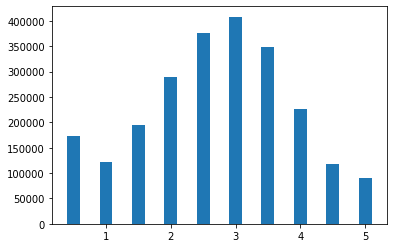

In [196]:
plt.bar(rounded_estimate_ratings_unique, rounded_estimate_ratings_counts, width=0.2)

In [ ]:
model_4 = PMF(4)
model_4.fit(train_ratings)

In [11]:
# PPC 
# get distribution of ratings from the entire data, and for each user
# get distribution of ratings from the predicted entire data, and predictions for each user
# check if the discrepancies are close to each other

# Discrepancies of original data
max_rating = max(ratings['rating'])
min_rating = min(ratings['rating'])
mean_rating = ratings['rating'].mean()
median_rating = ratings['rating'].median()
first_q_rating = np.quantile(ratings['rating'],0.25)
third_q_rating = np.quantile(ratings['rating'],0.75)

In [6]:
# POP-PC
# Cross validation POP-PC
# Splitting of train and test data
# Randomly remove ratings from train data, and keep possession of them to check later on 
# Train the model, then compare the entire data distribution and the ratings distributions of each user.